In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data

In [115]:
cbc = data.DataReader('0939.HK', 'yahoo',start='1/1/2000')

In [116]:
type(cbc)

#Proof that the data is stored as dataframe

pandas.core.frame.DataFrame

In [117]:
cbc.head()

#Check both head and tail to see when it starts and ends

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2005-10-27,2.30395,2.27969,2.27969,2.30395,3.749312e+09,1.23650
2005-10-28,2.27969,2.23119,2.25544,2.27969,2.176332e+09,1.22348
2005-10-31,2.27969,2.25544,2.27969,2.27969,2.911422e+08,1.22348
2005-11-01,2.27969,2.25544,2.27969,2.27969,3.325923e+08,1.22348
2005-11-02,2.27969,2.25544,2.25544,2.27969,1.771839e+08,1.22348


In [118]:
cbc.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-08-12,5.86,5.72,5.76,5.85,185020391.0,5.85
2020-08-13,5.88,5.75,5.87,5.80,186107962.0,5.80
2020-08-14,5.86,5.76,5.76,5.80,169549682.0,5.80
2020-08-17,5.93,5.79,5.80,5.86,212350300.0,5.86
2020-08-18,5.90,5.84,5.88,5.88,146842194.0,5.88


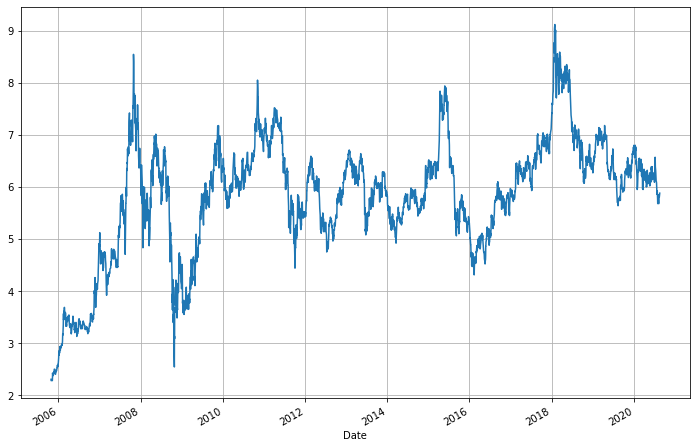

In [119]:
cbc['Close'].plot(grid=True,figsize=(12,8))

#12:8 is a good proportion

np.round(number,decimals)

cbc['Close'].rolling(window=42).mean() <- This represents the number
,2 <- represents the rounding decimal

In [120]:
cbc['42d'] = np.round(cbc['Close'].rolling(window=42).mean(),2)
cbc['252d'] = np.round(cbc['Close'].rolling(window=252).mean(),2)

#cbc is a Pandas object so can call the rolling and mean functions. NP itself does not have rolling function.
#42 days is the short window, 252 is about 1 year, the long window

In [121]:
cbc.tail()

#Check that 42d and 252d are added as new columns

,High,Low,Open,Close,Volume,Adj Close,42d,252d
Date,,,,,,,,
2020-08-12,5.86,5.72,5.76,5.85,185020391.0,5.85,6.08,6.21
2020-08-13,5.88,5.75,5.87,5.80,186107962.0,5.80,6.07,6.21
2020-08-14,5.86,5.76,5.76,5.80,169549682.0,5.80,6.06,6.21
2020-08-17,5.93,5.79,5.80,5.86,212350300.0,5.86,6.06,6.21
2020-08-18,5.90,5.84,5.88,5.88,146842194.0,5.88,6.05,6.21


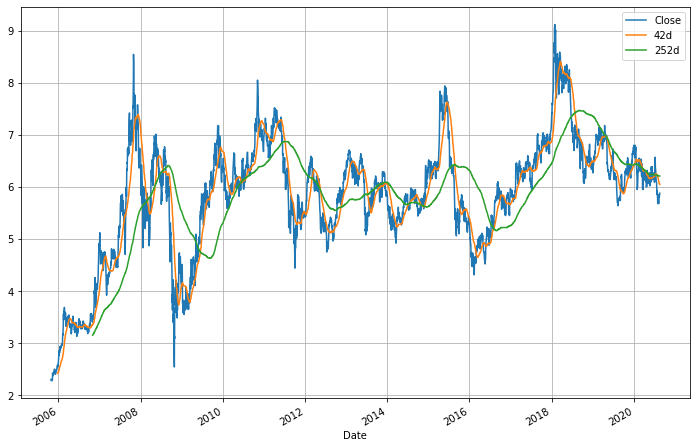

In [122]:
cbc[['Close','42d','252d']].plot(grid=True,figsize=(12,8))

#To plot all three values in the same chart, use [] to include all three parameters

In [123]:
cbc['42-252'] = (cbc['42d'] - cbc['252d'])/cbc['42d']

#Create a new column to show the difference between the short window vs long to see if positive or negative
#If short line is above the long line, the value will be positive and vice versa 

In [124]:
cbc.tail()

#Check the new '42-252' values, key point is to check if +ve or -ve

,High,Low,Open,Close,Volume,Adj Close,42d,252d,42-252
Date,,,,,,,,,
2020-08-12,5.86,5.72,5.76,5.85,185020391.0,5.85,6.08,6.21,-0.021382
2020-08-13,5.88,5.75,5.87,5.80,186107962.0,5.80,6.07,6.21,-0.023064
2020-08-14,5.86,5.76,5.76,5.80,169549682.0,5.80,6.06,6.21,-0.024752
2020-08-17,5.93,5.79,5.80,5.86,212350300.0,5.86,6.06,6.21,-0.024752
2020-08-18,5.90,5.84,5.88,5.88,146842194.0,5.88,6.05,6.21,-0.026446


In [125]:
cbc['42-252'].max()

#Check the max difference

0.2878998609179416

In [126]:
cbc.count()

High         3648
Low          3648
Open         3648
Close        3648
Volume       3648
Adj Close    3648
42d          3607
252d         3397
42-252       3397
dtype: int64

numpy.where(condition[, x, y]) function returns the indices of elements in an input array where the given condition is satisfied.

Parameters:
condition : When True, yield x, otherwise yield y.
x, y : Values from which to choose. x, y and condition need to be broadcastable to some shape.

We will have 3 basic states/rules:

1) Buy Signal (go long) – the 42d moving average is for the first time X points above the 252d tend.

2) Park in Cash – no position.

3) Sell Signal (go short) – the 42d moving average is for the first time X points below the 252d trend.

The first step in creating these signals is to add a new column to the DataFrame which is just the difference between the two moving averages:

cbc['42-252'] = cbc['42d'] - cbc['252d']
The next step is to formalise the signals by adding a further column which we will call Stance. We also set our signal threshold ‘X’ to 0.01 (this is somewhat arbitrary and can be optimised at some point)

In [127]:
X = 0.01
cbc['Stance'] = np.where(cbc['42-252'] > X, 1, 0)
cbc['Stance'] = np.where(cbc['42-252'] < -X, -1, cbc['Stance'])
cbc['Stance'].value_counts()

#The second line means that if X is +ve and greater that 0.01, then stance = 1, else 0
#The third line means if the value is greater than -0.01, then stance = -1, else stick with the previous stance's value
#The last line does a count of how many times the stances of each value

 1    1744
-1    1283
 0     621
Name: Stance, dtype: int64

Showing that during the time period we have chosen to backtest, on 1067 trading dates the 42d moving average lies more than 0.01 below the 252d moving average, and on 1486 the 42d moving average lies more than 0.01 above the 252d moving average.

A quick plot shows a visual representation of this ‘Stance’. I have set the ‘ylim’ (which is the y axis limits) to just above 1 and just below -1 so we can actually see the horizontal parts of the line.

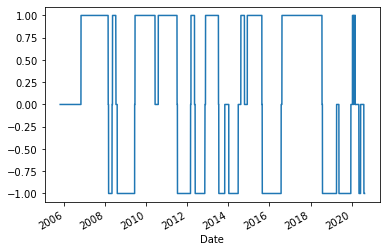

In [128]:
cbc['Stance'].plot(lw=1.5,ylim=[-1.1,1.1])

So in this model, our investor is either long the market, short the market or flat – this allows us to work with market returns and simply multiply the day’s market return by -1 if he is short, 1 if he is long and 0 if he is flat the previous day.

So we add yet another column to the DataFrame to hold the daily log returns of the index and then multiply that column by the ‘Stance’ column to get strategy returns.

Note how we have shifted the sp[‘Close’] series down so that we are using the ‘Stance’ at the close of the previous day to calculate the return on the next day

Now we can plot the returns of the CBC versus the returns on the moving average crossover strategy on the same chart for comparison.

In [129]:
cbc['Market Returns'] = np.log(cbc['Close'] / cbc['Close'].shift(1))
cbc['Strategy'] = cbc['Market Returns'] * cbc['Stance'].shift(1)

In [130]:
cbc.tail()

,High,Low,Open,Close,Volume,Adj Close,42d,252d,42-252,Stance,Market Returns,Strategy
Date,,,,,,,,,,,,
2020-08-12,5.86,5.72,5.76,5.85,185020391.0,5.85,6.08,6.21,-0.021382,-1,0.008584,-0.008584
2020-08-13,5.88,5.75,5.87,5.80,186107962.0,5.80,6.07,6.21,-0.023064,-1,-0.008584,0.008584
2020-08-14,5.86,5.76,5.76,5.80,169549682.0,5.80,6.06,6.21,-0.024752,-1,0.000000,-0.000000
2020-08-17,5.93,5.79,5.80,5.86,212350300.0,5.86,6.06,6.21,-0.024752,-1,0.010292,-0.010292
2020-08-18,5.90,5.84,5.88,5.88,146842194.0,5.88,6.05,6.21,-0.026446,-1,0.003407,-0.003407


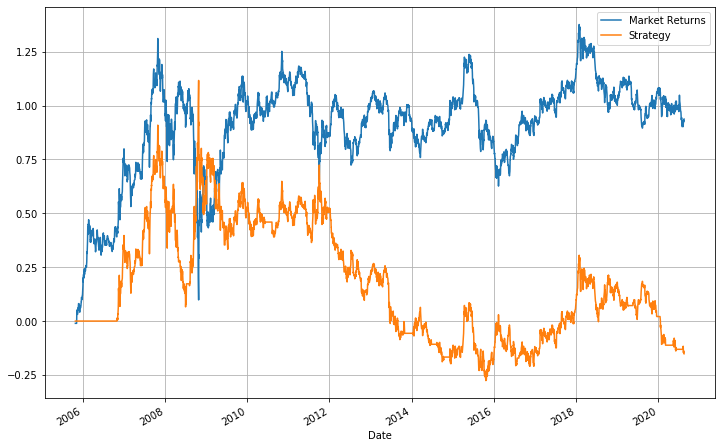

In [131]:
cbc[['Market Returns','Strategy']].cumsum().plot(grid=True,figsize=(12,8))